In [1]:
import pandas as pd

import os
import sys
# sys.path.insert(0, os.path.abspath(
#     os.path.join(os.path.dirname('__file__'), '..')))

#print(os.getcwd())
#data = pd.read_excel('data/features/hopitalfeatures/Export complet CH Beaune.xlsx')

etabs = ['CH Beaune',
        'CH Chatillon Montbard',
        'CH Chaumont',
        'CH Langres',
        'CH privé Dijon',
        'CH Semur',
        'CHU Besançon',
        'CHU Dijon',
        'HNFC']

nbr_elements = len(etabs)

data = []
for etab in etabs:
    data.append(pd.read_excel('../data/features/hopitalfeatures/Export complet '+etab+'.xlsx', sheet_name='Volumes', usecols='A:B'))
    data[-1][etabs[etabs.index(etab)]] = data[-1]['Total']
    data[-1] = data[-1].drop(columns=['Total'])


#data = pd.read_excel('../data/features/hopitalfeatures/Export complet CH Beaune.xlsx', sheet_name='Volumes', usecols='A:B')

#data = pd.concat(data, axis=1)

for i in range(1, len(data)):
    data[0] = pd.merge(data[0], data[i], on='date_entree', how='outer')

data = data[0]
data_wide = data.copy(deep=True)
data_wide.set_index('date_entree', inplace=True)
# data_wide['date'] = data_wide['date_entree']
# data_wide = data_wide.drop(columns=['date_entree'])
data_wide = data_wide.T
#data_wide['id'] = data_wide.index
data_wide.reset_index(inplace=True)
data_wide.columns.name = None
data_wide.rename(columns={'index': 'id'}, inplace=True)
data_wide.set_index('id', inplace=True)
data_wide.fillna(0, inplace=True)
#data_wide.drop(columns=['date_entree'], inplace=True)
# data_wide['id'] = data_wide.index
# data_wide.reset_index(inplace=True)
data_wide

KeyboardInterrupt: 

In [147]:
df_melted = data.melt(id_vars=['date_entree'], var_name='Hospital', value_name='Value')
df_melted.sort_values(by=['date_entree'], inplace=True)
df_melted.fillna(0, inplace=True)
df_melted

,date_entree,Hospital,Value
0,2016-01-01,CH Beaune,56.0
2922,2016-01-01,CH Chatillon Montbard,33.0
23376,2016-01-01,HNFC,158.0
20454,2016-01-01,CHU Dijon,131.0
5844,2016-01-01,CH Chaumont,56.0
...,...,...,...
11687,2023-12-31,CH Langres,32.0
20453,2023-12-31,CHU Besançon,156.0
2921,2023-12-31,CH Beaune,45.0
5843,2023-12-31,CH Chatillon Montbard,24.0


In [148]:
from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters

df = df_melted[['date_entree', 'Hospital', 'Value']]
extracted_features = extract_features(df, column_id='Hospital', column_sort='date_entree', default_fc_parameters=MinimalFCParameters())
extracted_features 

Feature Extraction: 100%|██████████| 9/9 [00:03<00:00,  3.00it/s]


,Value__sum_values,Value__median,Value__mean,Value__length,Value__standard_deviation,Value__variance,Value__root_mean_square,Value__maximum,Value__absolute_maximum,Value__minimum
CH Beaune,172755.0,60.0,59.122177,2922.0,11.351357,128.853314,60.202036,95.0,95.0,0.0
CH Chatillon Montbard,94266.0,32.0,32.260780,2922.0,8.747568,76.519947,33.425707,72.0,72.0,0.0
CH Chaumont,158310.0,54.0,54.178645,2922.0,10.145430,102.929756,55.120371,101.0,101.0,11.0
CH Langres,109322.0,37.0,37.413415,2922.0,7.909104,62.553934,38.240261,70.0,70.0,11.0
CH Semur,175039.0,60.0,59.903833,2922.0,10.962539,120.177268,60.898657,118.0,118.0,20.0
CH privé Dijon,183454.0,75.0,62.783710,2922.0,39.213875,1537.728030,74.023795,143.0,143.0,0.0
CHU Besançon,506607.0,179.0,173.376797,2922.0,36.605590,1339.969249,177.198992,269.0,269.0,69.0
CHU Dijon,504446.0,179.0,172.637235,2922.0,37.465766,1403.683596,176.655876,268.0,268.0,35.0
HNFC,608817.0,230.0,208.356263,2922.0,84.132108,7078.211544,224.701010,362.0,362.0,0.0


In [149]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MaxAbsScaler
from sklearn.decomposition import PCA

prep = MaxAbsScaler()

extracted_data = False
pca_dim = 2

if extracted_data:
    scaled_data = prep.fit_transform(extracted_features)
else:
    scaled_data = prep.fit_transform(data_wide)

pca = PCA(n_components=pca_dim)
scaled_data = pca.fit_transform(scaled_data)

In [150]:
from sklearn.metrics import silhouette_score
biggest = (0, 0)
for n_cluster in range(2, nbr_elements):
    kmeans = KMeans(n_clusters=n_cluster, random_state=0)
    kmeans.fit(scaled_data)
    score = silhouette_score(scaled_data, kmeans.labels_)
    if score > biggest[1]:
        biggest = (n_cluster, score)
    print(n_cluster, score)
print(biggest)

2 0.7434901610661907
3 0.7356468163088157
4 0.49259876676843256
5 0.6334820803426193
6 0.440674874686431
7 0.24628683753014224
8 0.08068714035517446
(2, 0.7434901610661907)


In [151]:

kmeans = KMeans(n_clusters=biggest[0], random_state=0)
kmeans.fit(scaled_data)

KMeans(n_clusters=2, random_state=0)

In [152]:
for cluster in range(kmeans.n_clusters):
    print(f"Cluster {cluster}")
    cluster_data = data_wide[kmeans.labels_ == cluster]
    for i in range(min(5, cluster_data.shape[0])):
        print(cluster_data.index[i])
    print()

Cluster 0
CH Beaune
CH Chatillon Montbard
CH Chaumont
CH Langres
CH privé Dijon

Cluster 1
CHU Besançon
CHU Dijon
HNFC



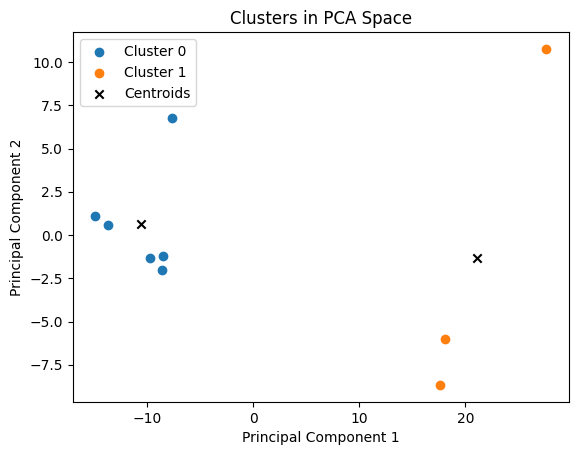

In [153]:
import matplotlib.pyplot as plt

for cluster in range(kmeans.n_clusters):
    cluster_points = scaled_data[kmeans.labels_ == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")

# Plot the cluster centroids as black 'X' markers
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            color='black', marker='x', label='Centroids')

plt.title("Clusters in PCA Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()

# Display the plot
plt.show()